In [2]:
import os
import sys
import cv2
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

sys.path.append('/home/hyunjoon/github/tracking-pytorch/')

In [3]:
from pysot.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker
from pysot.utils.bbox import get_axis_aligned_bbox, IoU
from pysot.utils.model_load import load_pretrain
from toolkit.datasets import DatasetFactory

In [4]:
torch.set_num_threads(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
# fn_config = 'experiments/baseline/config.yaml'
# snapshot = 'experiments/baseline/snapshot/checkpoint_e99.pth'
fn_config = '/home/hyunjoon/github/tracking-pytorch/experiments/siamcar_mobilenetv2_2gpu/config.yaml'
snapshot = '/home/hyunjoon/github/tracking-pytorch/experiments/siamcar_mobilenetv2_2gpu/snapshot/checkpoint_e1.pth'

In [6]:
cfg.merge_from_file(fn_config)
# cfg.TRACK.LR = 0.1
cfg.TRACK.WINDOW_INFLUENCE = float(np.power(0.42, 0.333))

# create model
model = ModelBuilder()

# load model
model = load_pretrain(model, snapshot).cuda().eval()

# build tracker
tracker = build_tracker(model)

In [7]:
# test image sequence
test_name = 'basketball'

# path_seq = '~/dataset_jinwook/got-10k/val/GOT-10k_Val_000001'
# fn_gt = '~/dataset_jinwook/got-10k/val/GOT-10k_Val_000001/groundtruth.txt'
path_seq = '/home/hyunjoon/dataset_jinwook/vot2018/{}/'.format(test_name)
fn_gt = '/home/hyunjoon/dataset_jinwook/vot2018/{}/groundtruth.txt'.format(test_name)

path_seq = os.path.expanduser(path_seq)
fn_gt = os.path.expanduser(fn_gt)

gt_seq = open(fn_gt, 'r').read().splitlines()
gt_seq = [np.fromstring(l, sep=',') for l in gt_seq]
gt_seq = np.stack(gt_seq, axis=0)

if gt_seq.shape[1] == 8:
    x0 = np.min(gt_seq[:, 0::2], axis=-1)
    y0 = np.min(gt_seq[:, 1::2], axis=-1)
    x1 = np.max(gt_seq[:, 0::2], axis=-1)
    y1 = np.max(gt_seq[:, 1::2], axis=-1)
    
    gt_seq = np.stack([x0, y0, x1-x0, y1-y0], axis=-1)

files_seq = [os.path.join(path_seq, '{:08d}.jpg'.format(i)) for i in range(1, len(gt_seq)+1)]

In [8]:
def _iou(lhs, rhs):
    lhs = np.transpose(np.reshape(lhs, (-1, 4)), (1, 0))
    rhs = np.transpose(np.reshape(rhs, (-1, 4)), (1, 0))
    d = np.minimum(lhs[2:]+lhs[:2], rhs[2:]+rhs[:2]) - np.maximum(lhs[:2], rhs[:2])
    d = np.maximum(d, 0.0)
    I = d[0] * d[1]
    A = lhs[2]*lhs[3] + rhs[2]*rhs[3]
    return (I / (A - I)).ravel()

In [30]:
img = cv2.imread(files_seq[0])
tracker.init(img, gt_seq[0])

if not os.path.exists('./result_images/{}'.format(test_name)):
    os.makedirs('./result_images/{}'.format(test_name))

plt.figure(figsize=(12,12))

ft0 = None # template
ft1 = None
ix0 = -1
iy0 = -1
att_k = None

print('Tracking started, total {} frames.'.format(len(files_seq)))
for ii, fn in enumerate(files_seq[1:], 1):
    t_img = cv2.imread(fn)
    res = tracker.track(t_img)
    
    rbb = np.array(res['bbox'])
    best_idx = res['best_idx']
#     best_score = res['score'][best_idx]
#     print(best_score)

#     output = res['output']
    gt_bb = gt_seq[ii]
    iou = _iou(rbb, gt_bb)
   
    if ii > 50:
        break;
    
    if iou < 0.1:
        print('Miss at frame {}'.format(ii))
        break

#     plt.imshow(t_img[:, :, ::-1])
#     rect = plt.Rectangle((rbb[0], rbb[1]),
#                          rbb[2],
#                          rbb[3], fill=False,
#                          edgecolor=[1, 0, 0], linewidth=3.5)
#     plt.gca().add_patch(rect)
    
#     gtbb = gt_seq[ii]
#     rect = plt.Rectangle((gtbb[0], gtbb[1]),
#                          gtbb[2],
#                          gtbb[3], fill=False,
#                          edgecolor=[0, 1, 0], linewidth=2.5)
#     plt.gca().add_patch(rect)
#     plt.savefig('./result_images/{}/res_{:04d}.png'.format(test_name, ii))
#     plt.clf()

Tracking started, total 725 frames.


<Figure size 864x864 with 0 Axes>

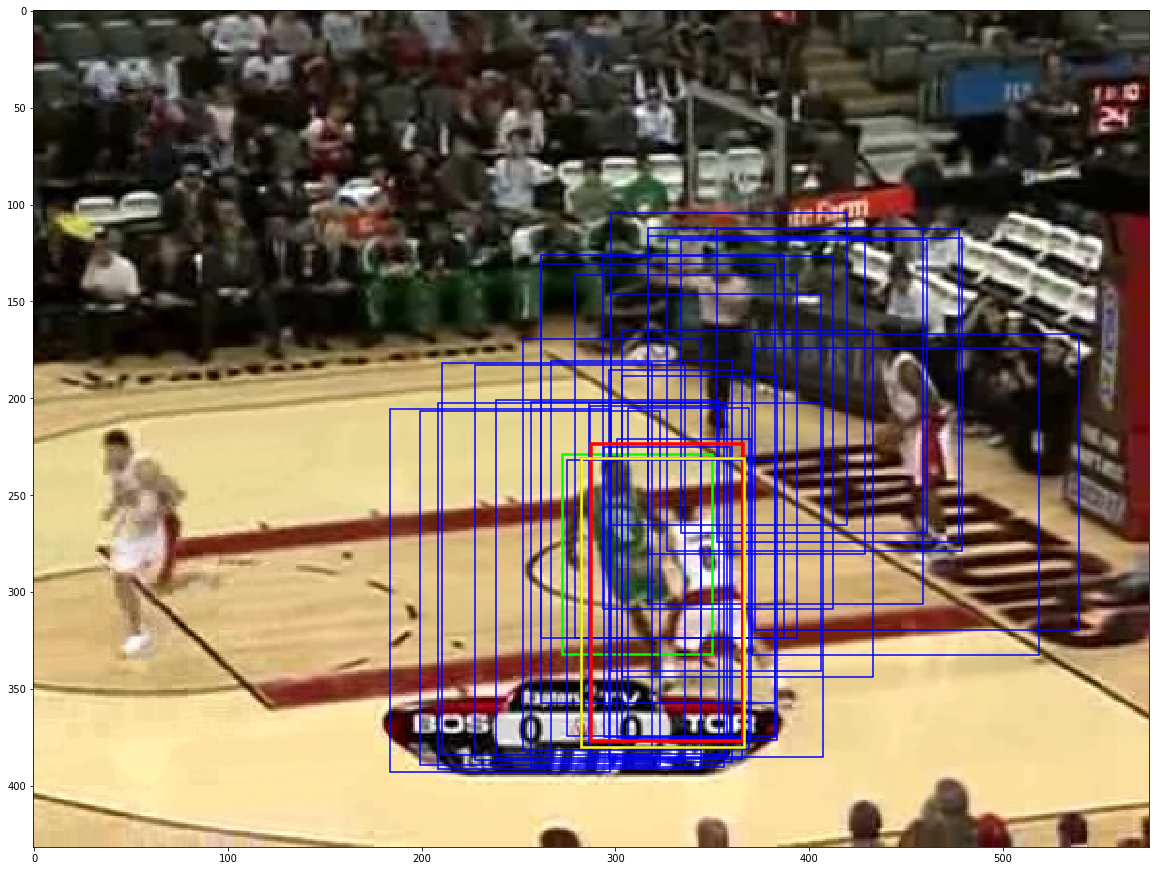

In [31]:
rbb = res['bbox']
plt.figure(figsize=(20,20))
plt.imshow(t_img[:, :, ::-1])

gtbb = gt_seq[ii]
rect = plt.Rectangle((gtbb[0], gtbb[1]),
                     gtbb[2],
                     gtbb[3], fill=False,
                     edgecolor=[0, 1, 0], linewidth=2.5)
plt.gca().add_patch(rect)

for pbb in res['pred_bbox']:
    rect = plt.Rectangle((pbb[0], pbb[1]),
                         pbb[2],
                         pbb[3], fill=False,
                         edgecolor=[0, 0, 1], linewidth=1.5)
    plt.gca().add_patch(rect)
    
rect = plt.Rectangle((rbb[0], rbb[1]),
                     rbb[2],
                     rbb[3], fill=False,
                     edgecolor=[1, 0, 0], linewidth=3.5)
plt.gca().add_patch(rect)

midx = np.argmax(_iou(gt_bb, res['pred_bbox']))
bbb = res['pred_bbox'][midx]
rect = plt.Rectangle((bbb[0], bbb[1]),
                     bbb[2],
                     bbb[3], fill=False,
                     edgecolor=[1, 1, 0], linewidth=2.5)
plt.gca().add_patch(rect)

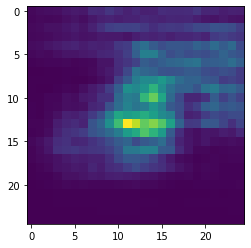

In [25]:
plt.imshow(res['ctr_rpn'].reshape((25, 25)))

In [26]:
np.max(res['ctr_rpn'])

0.31759825

In [27]:
res['pred_bbox']

array([[230.97694 , 200.2898  , 123.70389 , 177.57031 ],
       [288.90033 , 222.06488 ,  79.70592 , 150.78242 ],
       [303.36096 , 198.26227 ,  93.545944, 164.99477 ],
       [259.4017  , 215.38245 , 104.41948 , 165.0205  ],
       [289.37958 , 217.73462 ,  75.52177 , 154.41656 ],
       [222.82637 , 191.2833  , 122.42766 , 189.8263  ],
       [271.94244 , 222.86359 , 148.19212 , 149.91492 ],
       [266.52637 , 219.32771 , 119.79578 , 158.04054 ],
       [307.14694 , 137.79196 , 151.0232  , 191.07436 ],
       [297.88672 , 176.91852 , 105.72294 , 173.31584 ],
       [197.38226 , 209.07263 , 129.68645 , 176.43993 ],
       [254.98991 , 162.9381  , 132.24605 , 200.41687 ],
       [285.80112 , 217.3792  , 117.6397  , 149.52975 ],
       [234.58667 , 240.61531 , 146.93994 , 160.4019  ],
       [261.62173 , 183.00288 , 103.59604 , 201.59702 ],
       [288.38336 , 113.97815 , 140.33464 , 159.66467 ],
       [278.6968  , 153.17581 , 120.58123 , 195.15709 ],
       [210.6287  , 200.99402 ,

In [28]:
np.around(res['ctr_rcnn'], 3)

array([0.031, 0.049, 0.016, 0.031, 0.039, 0.009, 0.011, 0.013, 0.006,
       0.008, 0.005, 0.007, 0.015, 0.01 , 0.009, 0.01 , 0.004, 0.008,
       0.01 , 0.007, 0.007, 0.007, 0.004, 0.008, 0.005, 0.017, 0.004,
       0.01 , 0.008, 0.007, 0.004, 0.006], dtype=float32)

In [29]:
np.around(res['cls_rcnn'], 3)

array([0.157, 0.37 , 0.091, 0.201, 0.321, 0.053, 0.108, 0.113, 0.036,
       0.059, 0.038, 0.054, 0.157, 0.085, 0.101, 0.098, 0.029, 0.097,
       0.07 , 0.066, 0.067, 0.068, 0.05 , 0.069, 0.056, 0.22 , 0.043,
       0.137, 0.113, 0.059, 0.036, 0.065], dtype=float32)

In [16]:
np.around(res['pscore'], 3)

array([0.733, 0.801, 0.781, 0.771, 0.786, 0.734, 0.77 , 0.791, 0.795,
       0.796, 0.775, 0.694, 0.754, 0.716, 0.728, 0.537, 0.678, 0.698,
       0.739, 0.228, 0.512, 0.598, 0.718, 0.769, 0.746, 0.277, 0.757,
       0.409, 0.587, 0.776, 0.78 , 0.659], dtype=float32)

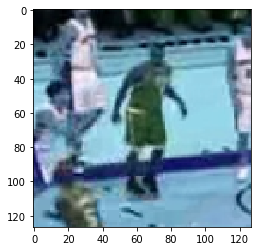

In [16]:
plt.imshow(tracker.img_z)

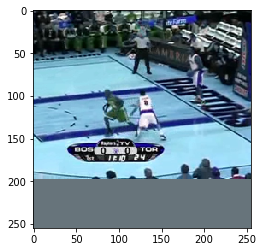

In [36]:
plt.imshow(tracker.img_x)

In [41]:
A = torch.zeros(3, 5)
B = torch.empty_like(A).normal_(0, 0.333)
C = torch.ones_like(A) * 2.0
C.pow_(B)

tensor([[0.7833, 1.1970, 0.8973, 0.8379, 1.0159],
        [1.0027, 1.0735, 0.8876, 1.3239, 0.9194],
        [0.8547, 0.9036, 0.6114, 0.7939, 0.6056]])

In [43]:
B

tensor([[-0.3523,  0.2594, -0.1564, -0.2552,  0.0228],
        [ 0.0039,  0.1023, -0.1720,  0.4048, -0.1212],
        [-0.2266, -0.1463, -0.7099, -0.3330, -0.7237]])